In [8]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import sys
import collections

In [2]:
inpaintDir = "/datasets_1/sagarj/BellLabs/Data/InpaitingFringe/"

In [3]:
ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImagesBottomUp.pkl"

In [4]:
with open(ImageList , 'rb') as f:
    imgList = pickle.load(f)

In [5]:
origPaths = {}
for k in imgList:
    if k[1]['label'] == 1:
        origPaths[k[0]] = {}
        origPaths[k[0]]['path'] = k[1]['path']
        origPaths[k[0]]['label'] = k[1]['label']

In [6]:
origPaths[origPaths.keys()[1]]

{'label': 1,
 'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7caffdc9f03587006f90.jpg'}

In [9]:
## import sys
import lmdb
import h5py
caffe_root = '/work/sagarj/caffe-rc5/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
from collections import defaultdict
import caffe
import cv2

model_root = "/work/sagarj/Work/BellLabs/caffe_models/caffe_model_1/"
#net_weights='caffe_beauty_augmented/caffe_model_beauty_augmented_iter_10000.caffemodel'
net_weights='caffe_model_beauty_4_votes/caffe_model_1_iter_24732.caffemodel'
net_definition='caffenet_deploy_1.prototxt'

test_lmdb_path = '../Data/validation_lmdb_beauty_augmented' # Test LMDB database path
mean_file_binaryproto = '../Data/cityAugmentedMean.npy' # Mean image file

#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227
#Size of images
#IMAGE_WIDTH = 224
#IMAGE_HEIGHT = 224
NCHANNELS = 3
meanR = 105.487823486
meanG = 113.741088867
meanB = 116.060394287

meanMat = np.zeros((NCHANNELS,IMAGE_WIDTH,IMAGE_HEIGHT))
meanMat[0,:,:].fill(meanR)
meanMat[1,:,:].fill(meanG)
meanMat[2,:,:].fill(meanB)

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def getScores(imageDict):

    caffe.set_mode_gpu()
    model_def = model_root+net_definition
    model_weights = model_root + net_weights

    net = caffe.Net(model_def,      # defines the structure of the model
                    model_weights,  # contains the trained weights
                    caffe.TEST)     # use test mode (e.g., don't perform dropout)
    
    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    mean = np.load(mean_file_binaryproto)
    print mean.shape
    feats = {}
    for k in imageDict:
        #featArray = predictImage(row['path'] , NN , TFormer)
        imgPath = imageDict[k]['path']
        #print imgPath
        path = imgPath.strip()
        if not os.path.exists(path):
            featArray = np.zeros((1,2))
        else:
            im =  transformer.preprocess('data',caffe.io.load_image(path))
            im = im - mean
            net.blobs['data'].data[...] = im - meanMat
            net.forward()
            featArray = net.blobs['prob'].data.copy()

        feats[k] = featArray
    return feats


In [10]:
origProbs = getScores(origPaths)

(3, 227, 227)


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
origProbs[origProbs.keys()[1]]

array([[ 0.4589918 ,  0.54100829]], dtype=float32)

In [12]:
predicted = []
actual = []
for k in origProbs:
    predicted.append(np.argmax(origProbs[k]))
    actual.append(origPaths[k]['label'])

In [13]:
origprecision , origrecall , origfscore , _ = precision_recall_fscore_support(actual, predicted)


print ( origprecision , origrecall , origfscore)

(array([ 0.,  1.]), array([ 0.        ,  0.83501006]), array([ 0.        ,  0.91008772]))


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [14]:
inpaintedFiles = os.listdir(inpaintDir)

In [15]:
labels = ['Sky', 'Building', 'Pole','RoadMarking','Road','Pavement','Tree','SignSymbol','Fence','Vehicle','Pedestrian', 'Bike']

In [16]:
inpaintPaths = {}
for i in labels: 
    inpaintPaths[i] = {}

In [17]:
inpaintedFiles[16].split('.')[0].split('_')

['5140d90efdc9f04926003b25', 'Pedestrian']

In [18]:
for i in inpaintedFiles:
    comps = i.split('.')[0].split('_')
    key = comps[0]
    #Take beautiful images only
    if key not in origPaths.keys():
        continue
    if len(comps) == 3:
        SegnetLbl = comps[1]+comps[2]
    else:
        SegnetLbl = comps[1]
    if SegnetLbl not in inpaintPaths:
        inpaintPaths[SegnetLbl] = {}
   
    if key not in inpaintPaths[SegnetLbl]:
        inpaintPaths[SegnetLbl][key] = {}
    inpaintPaths[SegnetLbl][key]['path'] = inpaintDir + i
    inpaintPaths[SegnetLbl][key]['label'] = origPaths[key]['label']
        

In [19]:
for k in inpaintPaths:
    print len(inpaintPaths[k])

497
497
497
497
497
497
497
497
497
497
497
497


In [20]:
inpaintedProbs = {}
for k in inpaintPaths.keys():
    inpaintedProbs[k] = getScores(inpaintPaths[k])

(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)


In [21]:
#inpaintedProbs['Building']['50e5f7d5d7c3df413b000571'][0][0]

In [22]:
inpaintedProbs.keys()

['Building',
 'Fence',
 'RoadMarking',
 'Tree',
 'Sky',
 'Pole',
 'Pedestrian',
 'Pavement',
 'Bike',
 'Vehicle',
 'SignSymbol',
 'Road']

In [23]:
predicted = {}
actual = []
changedActs = {}
once = 0
for k in inpaintedProbs:
    
    if k not in predicted.keys():
        predicted[k] = []
        changedActs[k] = []
    for j in inpaintedProbs[k]:
        predicted[k].append(np.argmax(inpaintedProbs[k][j]))
        changedActs[k].append((inpaintedProbs[k][j][0][1] - origProbs[j])[0][1])
        if once == 0:
            actual.append(origPaths[j]['label'])
    once+=1

In [24]:
#changedActs['Building']

In [25]:
actMedians = []
actStd = []
lbl = []
for k in changedActs:
    actMedians.append(np.median(changedActs[k]))
    actStd.append(np.std(changedActs[k]))
    lbl.append(k)

In [26]:
actStd

[0.023114072,
 0.0066442224,
 0.006773856,
 0.082917981,
 0.015774433,
 0.0059944908,
 0.0057585319,
 0.0066660666,
 0.0054474887,
 0.0080355722,
 0.0055000619,
 0.0089055737]

([<matplotlib.axis.XTick at 0x7f629c6e56d0>,
 <a list of 12 Text xticklabel objects>)

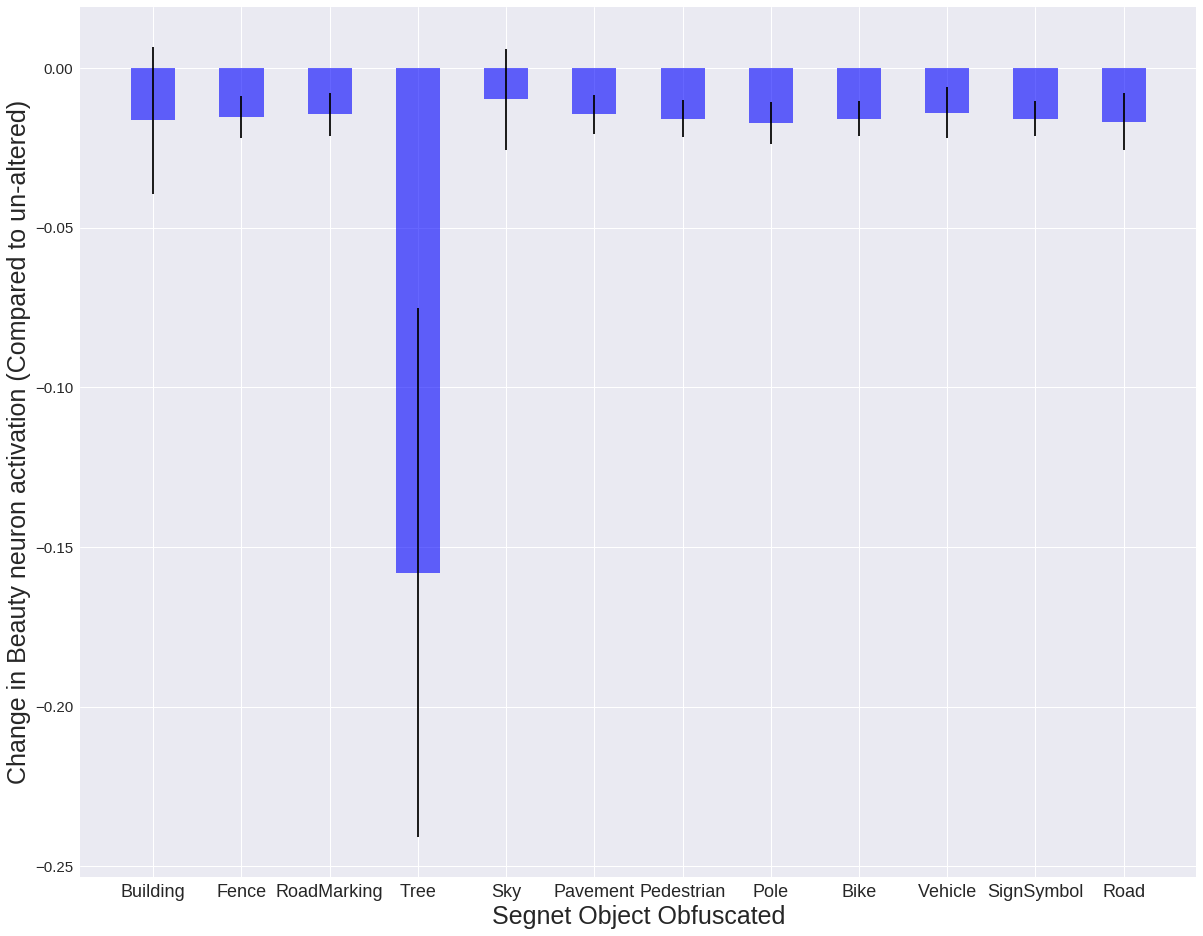

In [38]:
ind = np.arange(0,120,10)
width = 5       # the width of the bars
fig, ax = plt.subplots()
fig.set_size_inches(20,16)
plt.xlabel("Segnet Object Obfuscated" , fontsize = 25)
plt.ylabel("Change in Beauty neuron activation (Compared to un-altered)" , fontsize = 25 )
rects1 = ax.bar(ind, actMedians, width, color='b', yerr=actStd ,alpha=0.6)
plt.xticks(ind, lbl , fontsize=18)

In [28]:
predicted.keys()

['Building',
 'Fence',
 'RoadMarking',
 'Tree',
 'Sky',
 'Pavement',
 'Pedestrian',
 'Pole',
 'Bike',
 'Vehicle',
 'SignSymbol',
 'Road']

In [29]:
#predicted['Building']

In [30]:
precisions = []
recalls = []
fscores = []
for k in labels:
    precision , recall , fscore , _ = precision_recall_fscore_support(actual, predicted[k])
    
    precisions.append([(origprecision[0]- precision[0])/origprecision[0]*100 ,(origprecision[1]- precision[1])/origprecision[1] *100 ])
    recalls.append([(origrecall[0] - recall[0])/origrecall[0] *100 , (origrecall[1]-recall[1])/origrecall[1] * 100  ])
    fscores.append([(origrecall[1]-fscore[0])/origrecall[1] *100, (origfscore[1] -fscore[1]) /origfscore[1] *100 ])


print ( precisions) 
print( recalls )
print (fscores)

[[nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0], [nan, 0.0]]
[[nan, 1.4457831325301298], [nan, 9.6385542168674796], [nan, 8.19277108433735], [nan, 6.2650602409638561], [nan, 7.4698795180722977], [nan, 6.7469879518072329], [nan, 93.493975903614455], [nan, 7.7108433734939723], [nan, 6.7469879518072329], [nan, 6.9879518072289217], [nan, 7.9518072289156612], [nan, 7.4698795180722977]]
[[100.0, 0.79310619963297446], [100.0, 5.4935337680999217], [100.0, 4.6375936548014352], [100.0, 3.5143735211727227], [100.0, 4.2139955964607605], [100.0, 3.7932726380635788], [100.0, 88.676538213924388], [100.0, 4.3548740416210263], [100.0, 3.7932726380635788], [100.0, 3.9331959775682601], [100.0, 4.4960730293186257], [100.0, 4.2139955964607605]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [31]:
a = np.argsort([i[1] for i in recalls])[:5]
plotablesBeauty = [recalls[i][1] for i in a]

In [32]:
plotablesBeauty

[1.4457831325301298,
 6.2650602409638561,
 6.7469879518072329,
 6.7469879518072329,
 6.9879518072289217]

In [33]:
aLabels = [labels[i] for i in a]

In [34]:
b = np.argsort([i[1] for i in recalls])[-5:]
plotablesUgly = [recalls[i][1] for i in b]

In [35]:
bLabels = [labels[i] for i in b]

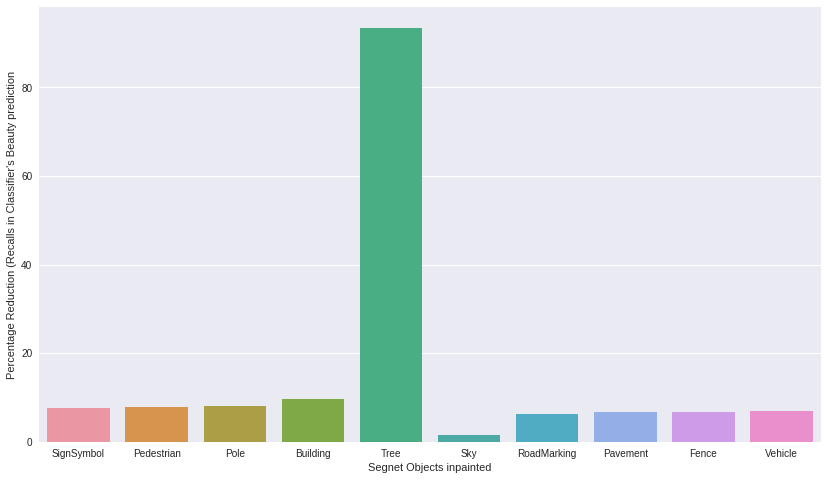

In [36]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=1.5) 
ax = sns.barplot(x=bLabels+aLabels, y=np.concatenate((plotablesUgly,plotablesBeauty) , axis = 0))
ax.set(xlabel='Segnet Objects inpainted', ylabel='Percentage Reduction (Recalls in Classifier\'s Beauty prediction')

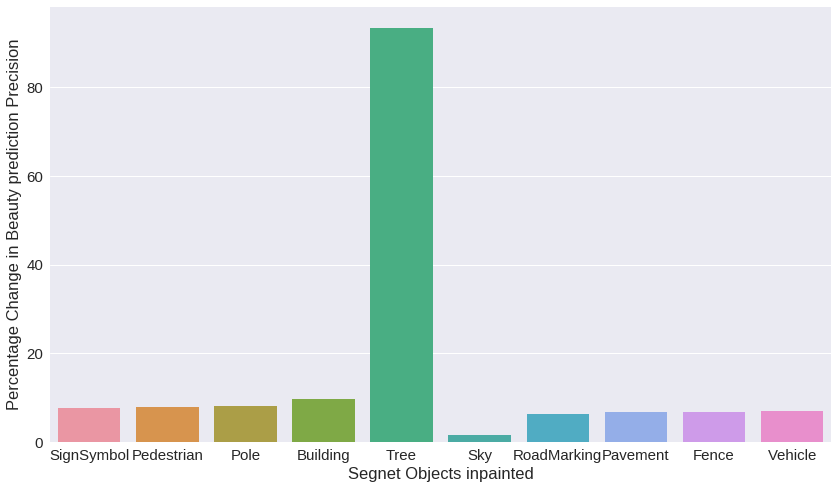

In [37]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=1.5) 
ax = sns.barplot(x=bLabels+aLabels, y=np.concatenate((plotablesUgly,plotablesBeauty) , axis = 0))
ax.set(xlabel='Segnet Objects inpainted', ylabel='Percentage Change in Beauty prediction Precision')